In [1]:
%matplotlib inline
import numpy as np
from copy import copy
import math, random
import matplotlib.pyplot as plt                   #   for plotting data
from matplotlib.patches import Ellipse      #  for drawing

In [2]:
class Landmarks:
    def __init__(self,array):
        self.positions = array
    
    def draw(self):
        xs = [ e[0] for e in self.positions]
        ys = [ e[1] for e in self.positions]
        plt.scatter(xs,ys,s=300,marker="*",label="landmarks",color="orange")

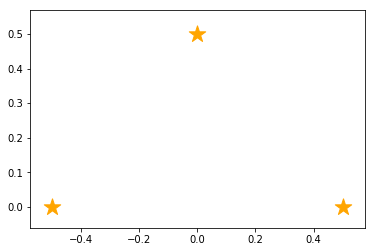

In [3]:
class Observation:
    def __init__(self,robot_pos, landmark,lid):
        self.sensor_max_range = 1.0
        self.sensor_min_range = 0.1
        self.sensor_max_angle = math.pi / 2
        self.sensor_min_angle = - math.pi /2 
        
        self.lid = None
        
        #true informations
        rx,ry,rt = robot_pos[0],robot_pos[1],robot_pos[2]
        lx,ly = landmark[0],landmark[1]
        
        distance = math.sqrt((rx-lx)**2 + (ry-ly)**2)
        if distance > self.sensor_max_range or distance < self.sensor_min_range:
            return
        
        direction = math.atan2(ly-ry, lx-rx) - rt                #landmark direction from the robot
        if direction > math.pi:    direction -= 2*math.pi
        if direction < -math.pi:   direction += 2*math.pi     
            
        if direction > self.sensor_max_angle or direction < self.sensor_min_angle:
            return
        
        orientation = direction + rt                  # absolute orientation of the landmark
        if orientation > math.pi:     orientation -= 2*math.pi
        if orientation < -math.pi:   orientation += 2*math.pi   
        
        sigma_distance = distance * 0.01 #1% gauss noise
        sigma_direction = math.pi * 1 / 180 #1deg  gauss noise
        sigma_orientation = math.pi * 1/180 #1deg gauss noise
        
        self.distance = random.gauss(distance, sigma_distance)   
        self.direction = random.gauss(direction, sigma_direction)
        self.orientation = random.gauss(orientation, sigma_orientation)

        self.lid = lid
        
    def ellipse(self,robot_pos):
        rx, ry, rt = robot_pos[0], robot_pos[1], robot_pos[2]
        proposed_lx = rx + self.distance * math.cos(rt + self.direction)
        proposed_ly = ry + self.distance * math.sin(rt + self.direction)
        
        e = copy(self.error_ellipse)
        e.shift(np.array([proposed_lx, proposed_ly]).T, rt + self.direction)
        
        eigen = np.linalg.eig(e.cov)
        
        v1 = eigen[0][0] * eigen[1][0]
        v2 = eigen[0][1] * eigen[1][1]
        v1_direction = math.atan2(v1[1],v1[0])
        
        elli = Ellipse([proposed_lx, proposed_ly],width=np.linalg.norm(v1),height=np.linalg.norm(v2),angle=v1_direction/3.14*180)
        elli.set_alpha(0.2)
        
        return elli
    
    def draw(self,sp,robot_pos):
        sp.add_artist(self.ellipse(robot_pos))
            
actual_landmarks = Landmarks(np.array([[-0.5,0.0],[0.5,0.0],[0.0,0.5]]))
actual_landmarks.draw()

In [4]:
class Robot:
    def __init__(self,x,y,rad):
        random.seed()
        
        self.actual_poses = [np.array([x,y,rad])]
        self.guess_poses = [np.array([x,y,rad])]
        self.observed = []
        
    def guessPose(self):
        return self.guess_poses[-1]
    
    def guess_motion(self,pos,fw,rot):
        # go straight with fw and rotate with rot after that
        px, py, pt = pos
        x = px + fw * math.cos(pt)
        y = py + fw * math.sin(pt)
        t = pt + rot
        
        return np.array([x,y,t])    
    
    def motion(self, pos, fw, rot):
        # go straight with fw and rotate with rot after that
        actual_fw = random.gauss(fw,fw/10)    #10% noise
        dir_error = random.gauss(0.0, math.pi / 180.0 * 3.0) # 3[deg] direction noise before motion
        
        px, py, pt = pos
        x = px + actual_fw * math.cos(pt + dir_error)
        y = py + actual_fw * math.sin(pt + dir_error)
        
        actual_rot = random.gauss(rot,rot/10) #10% noise
        t = pt + dir_error + actual_rot
        
        return np.array([x,y,t])
    
    def move(self,fw,rot):
        self.actual_poses.append(self.motion(self.actual_poses[-1],fw,rot))
        self.guess_poses.append(self.guess_motion(self.guess_poses[-1],fw,rot))
        
    def observation(self,landmarks):
        obss = []
        for i,landmark in enumerate(landmarks.positions):
            obs = Observation(self.actual_poses[-1],landmark,i)
            if obs.lid == None:
                continue
                
            obss.append(obs)
            
        return obss
            
    def draw(self,sp):        
        xs = [e[0] for e in self.guess_poses]
        ys = [e[1] for e in self.guess_poses]
        vxs = [math.cos(e[2]) for e in self.guess_poses]
        vys = [math.sin(e[2]) for e in self.guess_poses]
        plt.quiver(xs,ys,vxs,vys,color="gray",label="guess robot motion")
        
        xs = [e[0] for e in self.actual_poses]
        ys = [e[1] for e in self.actual_poses]
        vxs = [math.cos(e[2]) for e in self.actual_poses]
        vys = [math.sin(e[2]) for e in self.actual_poses]
        plt.quiver(xs,ys,vxs,vys,color="red",label="actual robot motion")

In [5]:
class ObservationEdge:
    def __init__(self,pose_id, landmark_id, robot_pose,dist,direc,ori):
        self.landmark_id = landmark_id
        self.pose_id = pose_id
        self.rx, self.ry, self.rt = robot_pose
        self.ldis, self.ldir, self.lori = dist, direc, ori
        
    def update(self,robot_poses):
        self.rx, self.ry, self.rt = robot_poses[self.pose_id]
        
    def draw(self):
        lx = self.rx + self.ldis * math.cos(self.ldir + self.rt)
        ly = self.ry + self.ldis * math.sin(self.ldir + self.rt)
        plt.plot([self.rx,  lx],[self.ry,  ly],color="pink")
        
    def __str__(self):
        return "NODE: %d, landmark: %d, pose: (%03f,%03f,%03f), obs: (%03f,%03f,%03f)" % (self.pose_id,self.landmark_id, self.rx,self.ry,self.rt, self.ldis,self.ldir,self.lori)
    
obs_edges = []

In [6]:
class VirtualMotionEdge:
    def __init__(self, obs1, obs2):
        self.id1, self.id2 = obs1.pose_id, obs2.pose_id
        
        self.x1, self.y1, self.t1 = obs1.rx, obs1.ry, obs1.rt
        self.x2, self.y2, self.t2 = obs2.rx, obs2.ry, obs2.rt
    
        self.hat_x = obs1.ldis * math.cos(obs1.ldir + obs1.rt) - obs2.ldis * math.cos(obs2.ldir + obs2.rt)
        self.hat_y = obs1.ldis * math.sin(obs1.ldir + obs1.rt) - obs2.ldis * math.sin(obs2.ldir + obs2.rt)
        self.hat_t = obs2.lori - obs1.lori + obs1.ldir - obs2.ldir
        
        self.cov1 = np.array([[(obs1.ldis * 0.1)**2,                                                                                 0, 0],
                                             [                                          0, (obs1.ldis * math.sin(math.pi*3 / 180))**2,0],
                                             [                                          0,                                                                                  0,(math.pi*6/180)**2]])
        
        self.cov2 = np.array([[(obs2.ldis * 0.1)**2,                                                                                 0, 0],
                                             [                                          0, (obs2.ldis * math.sin(math.pi*3 / 180))**2,0],
                                             [                                          0,                                                                                  0,(math.pi*6/180)**2]])
        
        
        c = math.cos(obs1.rt + obs1.ldir)
        s = math.sin(obs1.rt + obs1.ldir)
        self.rot1 = np.array([[  c,s,0],
                                             [-s,c,0],
                                             [ 0,0,1]])
        
        c = math.cos(obs1.rt + obs1.ldir + obs2.lori - obs1.lori - math.pi)
        s = math.sin(obs1.rt + obs1.ldir)
        self.rot2 = np.array([[  c,s,0],
                                             [-s,c,0],
                                             [ 0,0,1]])       
        
        self.cov = (self.rot1).dot(self.cov1).dot((self.rot1).T) + (self.rot2).dot(self.cov2).dot((self.rot2).T) 
        
        self.ex = obs2.rx - obs1.rx - self.hat_x
        self.ey = obs2.ry - obs1.ry - self.hat_y
        self.et = obs2.rt  - obs1.rt  - self.hat_t
        if self.et    >  math.pi: self.et -= 2 * math.pi
        elif self.et < -math.pi: self.et += 2 * math.pi
            
        self.e = np.array([self.ex,self.ey,self.et]).T
        
        self.matA = np.array([[-1,  0,   obs1.ldis * math.sin(obs1.rt + obs1.ldir)],
                                               [ 0, -1, -obs1.ldis * math.cos(obs1.rt + obs1.ldir)],
                                               [ 0,  0, -1]])
        
        self.matB = np.array([[1,0,-obs2.ldis * math.sin(obs2.rt + obs2.ldir)],
                                              [0,1, obs2.ldis * math.cos(obs2.rt + obs2.ldir)],
                                              [0,0,1]])
        
        self.info = np.linalg.inv(self.cov)

        self.matH_11 = (self.matA).T.dot(self.info.dot(self.matA))
        self.matH_12 = (self.matA).T.dot(self.info.dot(self.matB))
        self.matH_21 = (self.matB).T.dot(self.info.dot(self.matA))
        self.matH_22 = (self.matB).T.dot(self.info.dot(self.matB))
        
        self.b1 = (self.matA).T.dot(self.info.dot(self.e))
        self.b2 = (self.matB).T.dot(self.info.dot(self.e))
        
    def addInfo(self,h,b):
        h[self.id1*3:self.id1*3+3, self.id1*3:self.id1*3+3] += self.matH_11
        h[self.id1*3:self.id1*3+3, self.id2*3:self.id2*3+3] += self.matH_12
        h[self.id2*3:self.id2*3+3, self.id1*3:self.id1*3+3] += self.matH_21
        h[self.id2*3:self.id2*3+3, self.id2*3:self.id2*3+3] += self.matH_22

        b[self.id1*3:self.id1*3+3,0] += self.b1
        b[self.id2*3:self.id2*3+3,0] += self.b2
        
    def ellipse(self):
        
        eigen = np.linalg.eig(self.cov)
        
        v1 = eigen[0][0] * eigen[1][0]
        v2 = eigen[0][1] * eigen[1][1]
        v1_direction = math.atan2(v1[1],v1[0])
        
        elli = Ellipse([self.x1+ self.hat_x, self.y1+ self.hat_y],width=math.sqrt(np.linalg.norm(v1)),height=math.sqrt(np.linalg.norm(v2)),angle=v1_direction/3.14*180)
        elli.set_alpha(0.2)
        
        return elli
    
pos_edges = []

In [7]:
def draw(i=0):
    fig = plt.figure(i,figsize=(8, 8))
    sp = fig.add_subplot(111, aspect='equal')
    sp.set_xlim(-1.0,1.0)
    sp.set_ylim(-0.5,1.5)
    
    for e in obs_edges:
        e.draw()
        
    xs = [ e.x1 + e.hat_x for e in pos_edges]
    ys = [ e.y1 + e.hat_y for e in pos_edges]
    plt.scatter(xs,ys,color="blue") 
    
    es = [ e.ellipse() for e in pos_edges]
    for e in es:
        sp.add_artist(e)

    robot.draw(sp)
    
    actual_landmarks.draw()

    plt.legend()

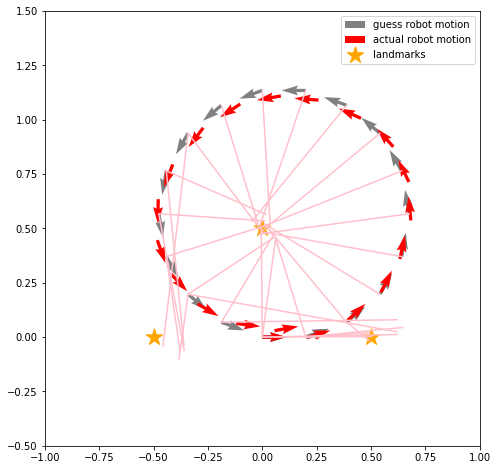

In [8]:
robot = Robot(0,0,0)
obss = robot.observation(actual_landmarks)
guess_id = 0
robot.observed.append(len(obss) > 0)
for obs in obss:
    e = ObservationEdge(guess_id, obs.lid, robot.guessPose(),obs.distance, obs.direction, obs.orientation)
    obs_edges.append(e)
if len(obss) > 0:
    guess_id += 1
#draw(0)

for i in range(1,20):
    robot.move(0.2,math.pi / 180.0 * 20)
    obss = robot.observation(actual_landmarks)
    robot.observed.append(len(obss) > 0)
    for obs in obss:
        e = ObservationEdge(guess_id, obs.lid, robot.guessPose(),obs.distance, obs.direction, obs.orientation)
        obs_edges.append(e)
    if len(obss) > 0:
        guess_id += 1
#    draw(i)
    
### remove no observation step
a = []
g = []
for i,obs in enumerate(robot.observed):
    if obs:
        a.append(robot.actual_poses[i])
        g.append(robot.guess_poses[i])

robot.actual_poses = a
robot.guess_poses = g
robot.observed = []
        
draw()

iteration: 1, diff: 0.357318
iteration: 2, diff: 0.000494
iteration: 3, diff: 0.000000
iteration: 4, diff: 0.000000


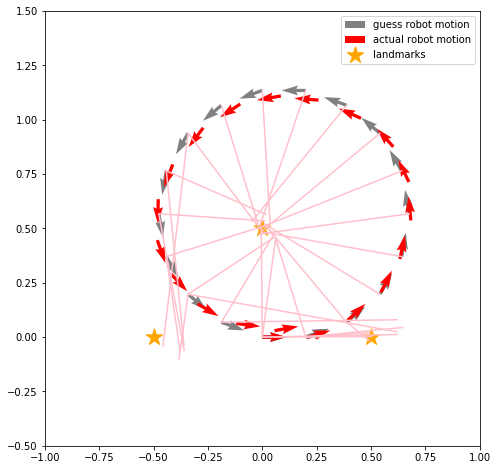

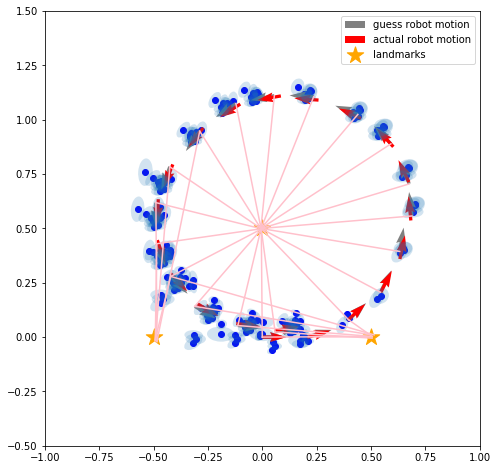

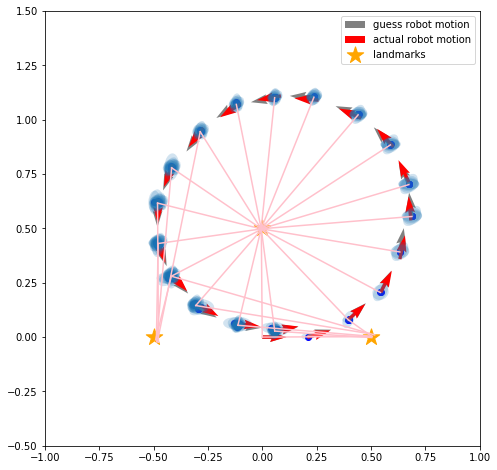

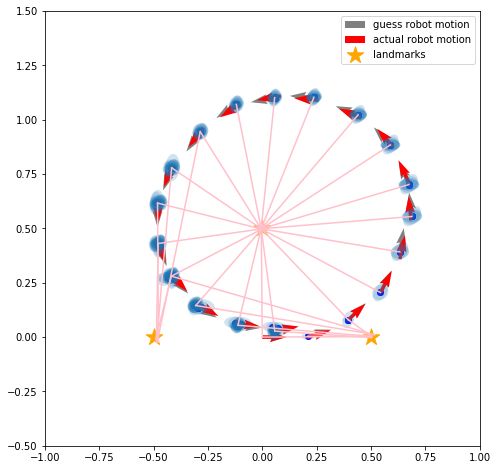

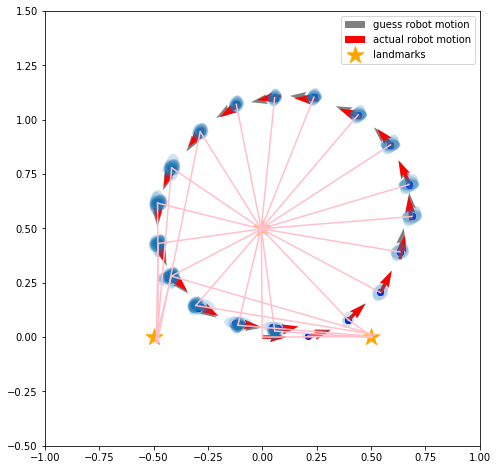

In [9]:
import itertools

draw(0)

for itr in range(1,20):
    pos_edges = []

    for i in range(len(actual_landmarks.positions)):
        es = list(filter(lambda e: e.landmark_id == i, obs_edges))
        ps = list(itertools.combinations(es,2))
        for p in ps:
            pos_edges.append(VirtualMotionEdge(p[0],p[1]))

    n = len(robot.guess_poses)*3
    matH = np.zeros((n,n))
    vecb = np.zeros((n,1))

    for e in pos_edges:
        e.addInfo(matH,vecb)

    matH[0:3,0:3] += np.identity(3)*10000

    #print(np.linalg.inv(matH))
    #print(vecb)
    delta = - np.linalg.inv(matH).dot(vecb)

    for i,p in enumerate(robot.guess_poses):
        p[0] += delta[i*3,0]
        p[1] += delta[i*3+1,0]
        p[2] += delta[i*3+2,0]

    for e in obs_edges:
        e.update(robot.guess_poses)
        
    draw(itr)
    
    diff = delta.T.dot(delta)
    print("iteration: %d, diff: %f" % (itr,diff))
    if diff[0,0] < 1.0e-10:
        break